# Final model

### Resources

- https://geemap.org/notebooks/46_local_rf_training/

## Setup

In [1]:
from google.colab import drive
import os
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import ee
import geemap
from geemap import ml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/land_cover_classification_kaza

/content/drive/MyDrive/land_cover_classification_kaza


In [4]:
user_id = 'ee-alexvmt'
asset_name = 'mufunta_random_forest'

In [5]:
ee.Authenticate()
ee.Initialize(project=user_id)

## Load train and test set

In [6]:
train = pd.read_csv('data/train.csv')
train

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,LC_Nr,LC_Out,Landcover
0,2006.000000,1215.000000,522.100000,701.937500,810.666667,1098.000000,1695.750000,1901.000000,2257.333333,2226.000000,7,Forest,Forest
1,1903.000000,1237.500000,404.000000,529.000000,551.000000,952.666667,1618.800000,1868.500000,1861.500000,2135.000000,7,Forest,Forest
2,2244.500000,1337.666667,476.500000,696.375000,735.000000,1156.250000,1856.625000,2145.750000,2619.000000,2523.500000,7,Forest,Forest
3,2029.000000,1238.000000,450.000000,622.000000,693.000000,1056.000000,1666.000000,1925.000000,2076.000000,2252.000000,7,Forest,Forest
4,2249.000000,1340.750000,498.000000,707.000000,797.500000,1241.500000,1904.416667,2156.500000,2371.600000,2507.500000,7,Forest,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,3092.666667,2532.000000,866.500000,1101.500000,1475.000000,1689.750000,1899.000000,2054.833333,2287.000000,2368.250000,3,Built-up,Built up
3301,3588.000000,3187.500000,1151.000000,1325.000000,2030.700000,2052.250000,2444.166667,2571.083333,2662.666667,2812.333333,3,Built-up,Built up
3302,3474.400000,2907.500000,1121.000000,1458.833333,1844.000000,2013.000000,2354.500000,2526.928571,2717.166667,2771.857143,3,Built-up,Built up
3303,3429.250000,3303.000000,1203.333333,1398.000000,1782.000000,1736.000000,1926.000000,2068.000000,2502.000000,2315.000000,3,Built-up,Built up


In [7]:
X_train = train.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_train

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A
0,2006.000000,1215.000000,522.100000,701.937500,810.666667,1098.000000,1695.750000,1901.000000,2257.333333,2226.000000
1,1903.000000,1237.500000,404.000000,529.000000,551.000000,952.666667,1618.800000,1868.500000,1861.500000,2135.000000
2,2244.500000,1337.666667,476.500000,696.375000,735.000000,1156.250000,1856.625000,2145.750000,2619.000000,2523.500000
3,2029.000000,1238.000000,450.000000,622.000000,693.000000,1056.000000,1666.000000,1925.000000,2076.000000,2252.000000
4,2249.000000,1340.750000,498.000000,707.000000,797.500000,1241.500000,1904.416667,2156.500000,2371.600000,2507.500000
...,...,...,...,...,...,...,...,...,...,...
3300,3092.666667,2532.000000,866.500000,1101.500000,1475.000000,1689.750000,1899.000000,2054.833333,2287.000000,2368.250000
3301,3588.000000,3187.500000,1151.000000,1325.000000,2030.700000,2052.250000,2444.166667,2571.083333,2662.666667,2812.333333
3302,3474.400000,2907.500000,1121.000000,1458.833333,1844.000000,2013.000000,2354.500000,2526.928571,2717.166667,2771.857143
3303,3429.250000,3303.000000,1203.333333,1398.000000,1782.000000,1736.000000,1926.000000,2068.000000,2502.000000,2315.000000


In [8]:
y_train = train['LC_Nr']
y_train

0       7
1       7
2       7
3       7
4       7
       ..
3300    3
3301    3
3302    3
3303    3
3304    3
Name: LC_Nr, Length: 3305, dtype: int64

In [9]:
test = pd.read_csv('data/test.csv')
test

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,LC_Nr,LC_Out,Landcover
0,1492.200000,754.666667,326.363636,454.545455,359.500000,741.000000,1498.500,1754.666667,1896.500000,1956.000000,7,Forest,Forest
1,1393.000000,654.000000,286.000000,404.000000,324.000000,656.000000,1472.000,1695.000000,1758.000000,1890.000000,7,Forest,Forest
2,1879.500000,1112.333333,387.750000,539.750000,563.666667,967.500000,1588.750,1797.000000,1792.000000,2065.250000,7,Forest,Forest
3,1854.666667,1055.000000,358.000000,486.600000,515.000000,882.333333,1581.000,1811.250000,1846.000000,2100.250000,7,Forest,Forest
4,2185.600000,1432.500000,491.800000,686.384615,810.200000,1173.285714,1643.125,1868.714286,2091.500000,2164.222222,7,Forest,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78316,2933.750000,2918.666667,972.400000,1253.000000,1621.333333,1959.000000,2026.000,2106.166667,1894.000000,2159.750000,3,Built-up,Built up
78317,3748.500000,3796.857143,1192.666667,1412.000000,1753.000000,2074.333333,2197.000,2339.500000,2432.000000,2625.000000,3,Built-up,Built up
78318,3832.000000,3842.883333,1321.200000,1558.500000,1933.800000,2081.000000,2198.000,2375.333333,2643.000000,2629.500000,3,Built-up,Built up
78319,3834.500000,3540.500000,1269.000000,1395.000000,1776.000000,1950.500000,2181.000,2431.500000,2635.000000,2786.500000,3,Built-up,Built up


In [10]:
X_test = test.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_test

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A
0,1492.200000,754.666667,326.363636,454.545455,359.500000,741.000000,1498.500,1754.666667,1896.500000,1956.000000
1,1393.000000,654.000000,286.000000,404.000000,324.000000,656.000000,1472.000,1695.000000,1758.000000,1890.000000
2,1879.500000,1112.333333,387.750000,539.750000,563.666667,967.500000,1588.750,1797.000000,1792.000000,2065.250000
3,1854.666667,1055.000000,358.000000,486.600000,515.000000,882.333333,1581.000,1811.250000,1846.000000,2100.250000
4,2185.600000,1432.500000,491.800000,686.384615,810.200000,1173.285714,1643.125,1868.714286,2091.500000,2164.222222
...,...,...,...,...,...,...,...,...,...,...
78316,2933.750000,2918.666667,972.400000,1253.000000,1621.333333,1959.000000,2026.000,2106.166667,1894.000000,2159.750000
78317,3748.500000,3796.857143,1192.666667,1412.000000,1753.000000,2074.333333,2197.000,2339.500000,2432.000000,2625.000000
78318,3832.000000,3842.883333,1321.200000,1558.500000,1933.800000,2081.000000,2198.000,2375.333333,2643.000000,2629.500000
78319,3834.500000,3540.500000,1269.000000,1395.000000,1776.000000,1950.500000,2181.000,2431.500000,2635.000000,2786.500000


In [11]:
y_test = test['LC_Nr']
y_test

0        7
1        7
2        7
3        7
4        7
        ..
78316    3
78317    3
78318    3
78319    3
78320    3
Name: LC_Nr, Length: 78321, dtype: int64

## Train random forest with default hyperparameters

In [12]:
rf_default = RandomForestClassifier()

In [13]:
rf_default.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
y_train_pred = rf_default.predict(X_train)
y_test_pred = rf_default.predict(X_test)

## Evaluation

### Train set classification metrics

In [15]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [16]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [17]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [18]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [19]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [20]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

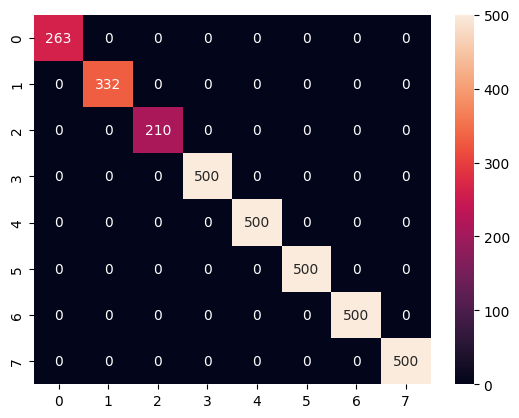

In [21]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [22]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.8473


In [23]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.6898


In [24]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.8423


In [25]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.7215


In [26]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.86      0.99      0.92       113
           2       0.09      0.80      0.17       143
           3       0.66      0.83      0.74        90
           4       0.98      0.88      0.92     17628
           5       0.50      0.78      0.61      3248
           6       0.54      0.79      0.64      8266
           7       0.95      0.87      0.91     35183
           8       0.94      0.80      0.86     13650

    accuracy                           0.85     78321
   macro avg       0.69      0.84      0.72     78321
weighted avg       0.89      0.85      0.86     78321



In [27]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  112,     0,     0,     0,     0,     0,     0,     1],
       [    0,   114,     2,    21,     6,     0,     0,     0],
       [    0,     9,    75,     5,     0,     1,     0,     0],
       [    0,  1012,    35, 15442,   642,   347,   132,    18],
       [    0,    22,     0,    57,  2534,   291,    16,   328],
       [    0,    42,     2,   110,   414,  6538,  1048,   112],
       [    0,     0,     0,    22,    28,  4222, 30651,   260],
       [   18,     2,     0,   119,  1442,   818,   352, 10899]])

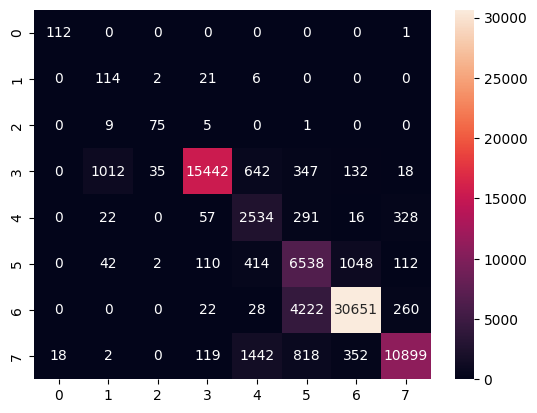

In [28]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Train random forest with optimized hyperparameters

Get optimized hyperparameters from notebook called `automl.ipynb`.

In [29]:
rf_optimized = RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=2,
                           min_samples_split=4, n_estimators=512, n_jobs=1,
                           random_state=1, warm_start=True)

In [30]:
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=2,
                       min_samples_split=4, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)

In [31]:
y_train_pred = rf_optimized.predict(X_train)
y_test_pred = rf_optimized.predict(X_test)

## Evaluation

### Train set classification metrics

In [32]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [33]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [34]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [35]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [36]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [37]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

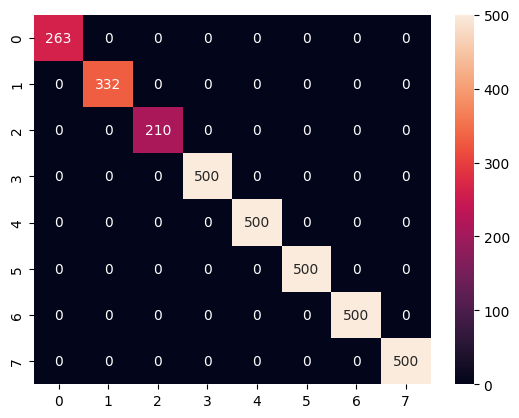

In [38]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [39]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.8515


In [40]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.7075


In [41]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.8533


In [42]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.7372


In [43]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.87      0.99      0.93       113
           2       0.11      0.83      0.19       143
           3       0.76      0.87      0.81        90
           4       0.98      0.88      0.93     17628
           5       0.52      0.79      0.63      3248
           6       0.53      0.79      0.64      8266
           7       0.95      0.87      0.91     35183
           8       0.94      0.81      0.87     13650

    accuracy                           0.85     78321
   macro avg       0.71      0.85      0.74     78321
weighted avg       0.89      0.85      0.87     78321



In [44]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  112,     0,     0,     0,     0,     0,     0,     1],
       [    0,   118,     2,    19,     3,     1,     0,     0],
       [    0,     6,    78,     4,     1,     1,     0,     0],
       [    0,   915,    23, 15591,   615,   332,   130,    22],
       [    0,    19,     0,    48,  2565,   297,    11,   308],
       [    0,    39,     0,   107,   377,  6509,  1120,   114],
       [    1,     0,     0,    13,    12,  4282, 30655,   220],
       [   16,     1,     0,   109,  1379,   778,   308, 11059]])

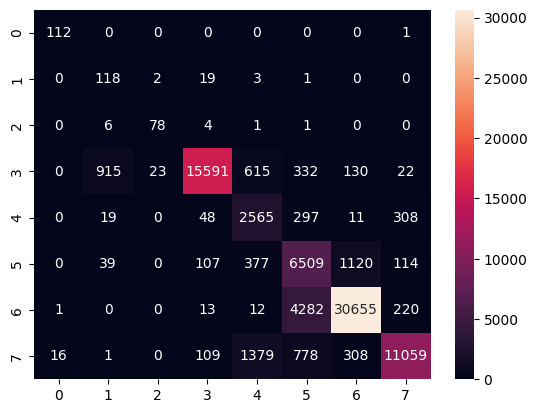

In [45]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Convert sklearn classifier object to a list of strings

In [46]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
start_time = time.perf_counter()
trees = ml.rf_to_strings(rf_default, X_train.columns)
end_time = time.perf_counter()
run_time = round((end_time - start_time) / 60, 2)
print('Run time: {} minutes.'.format(run_time))

Run time: 1.36 minutes.


In [47]:
# print the first tree to see the result
print(trees[0])

1) root 2065 9999 9999 (146.47513595019518)
  2) B4 <= 1188.400024 2065 0.8655 6
    4) B11 <= 1189.500000 1412 0.8019 6
      8) B8 <= 1087.500000 158 0.0000 1 *
      9) B8 > 1087.500000 1 0.0000 8 *
    5) B11 > 1189.500000 1412 0.8019 6
      10) B8A <= 1861.125000 1253 0.7644 6
        20) B6 <= 1060.319458 382 0.5100 8
          40) B12 <= 1867.250000 99 0.1199 8
            80) B3 <= 373.399994 1 0.0000 1 *
            81) B3 > 373.399994 95 0.0563 8
              162) B11 <= 1415.250000 94 0.0290 8
                324) B7 <= 1088.266663 12 0.0000 8 *
                325) B7 > 1088.266663 14 0.1800 8
                  650) B8A <= 1289.125000 1 0.0000 1 *
                  651) B8A > 1289.125000 1 0.0000 8 *
              163) B11 > 1415.250000 80 0.0000 8 *
          41) B12 > 1867.250000 4 0.0000 5 *
        21) B6 > 1060.319458 382 0.5100 8
          42) B12 <= 1483.333313 283 0.5414 8
            84) B4 <= 426.250000 11 0.0000 7 *
            85) B4 > 426.250000 97 0.4056 8
 

In [48]:
print(trees[1])

1) root 2106 9999 9999 (155.6623772719386)
  2) B6 <= 1874.666687 2106 0.8657 5
    4) B11 <= 1138.250000 1463 0.8032 8
      8) B7 <= 1023.500000 183 0.0000 1 *
      9) B7 > 1023.500000 1 0.0000 8 *
    5) B11 > 1138.250000 1463 0.8032 8
      10) B7 <= 1646.416687 1279 0.7632 8
        20) B4 <= 744.899994 432 0.4959 8
          40) B4 <= 474.399994 254 0.2769 8
            80) B7 <= 1298.099976 15 0.3810 7
              160) B2 <= 307.083328 1 0.0000 1 *
              161) B2 > 307.083328 3 0.0000 8 *
            81) B7 > 1298.099976 11 0.0000 7 *
          41) B4 > 474.399994 254 0.2769 8
            82) B8A <= 1797.750000 239 0.2144 8
              164) B3 <= 562.862762 210 0.1575 8
                328) B2 <= 462.166672 136 0.0571 8
                  656) B8A <= 1778.500000 119 0.0227 8
                    1312) B11 <= 1417.500000 116 0.0117 8
                      2624) B8 <= 1045.500000 13 0.0000 8 *
                      2625) B8 > 1045.500000 15 0.1107 8
                     

In [49]:
# number of trees we converted should equal the number of trees we defined for the model
n_trees = 100
len(trees) == n_trees

True

## Convert sklearn classifier to GEE classifier

At this point you can take the list of strings and save them locally to avoid training again. However, we want to use the model with EE so we need to create an ee.Classifier and persist the data on ee for best results.

In [50]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [51]:
ee_classifier.getInfo()

Output hidden; open in https://colab.research.google.com to view.

## Save trees to the cloud

Now we have the strings in a format that ee can use, we want to save it for later use. There is a function to export a list of tree strings to a feature collection.

In [52]:
# specify asset id where to save trees
asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_trees'
asset_id

'projects/ee-alexvmt/assets/mufunta_random_forest_trees'

In [53]:
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on
# check progress here: https://code.earthengine.google.com/tasks

In [54]:
# save ee classifier to be used in ee directly
classifier_asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_classifier'
task = ee.batch.Export.classifier.toAsset(
    ee_classifier, 'saved classifier', classifier_asset_id
)
task.start()

## Save trees locally

In [55]:
out_csv = os.path.expanduser('models/trees.csv')
ml.trees_to_csv(trees, out_csv)